# **GPT-3.5 vs GPT-4 vs ChatXML vs ChatXML w/ CoT: A Quantitative Analysis of Prompt Engineering (Part 2)**  

This post continues the analysis of *structured prompting methods* on model performance. The dataset used here is the *aba_MRPC_true_false eval* from OpenAI which contains 110 True/False questions on legal ethics from the ABA Model Rules of Professional Conduct. This challenging dataset shows notable gains when using prompt engineering techniques.

The results are summarized below: 

| Model        | Precision  | Recall     | F1-score | Accuracy | Latency (min) |    
|:--|:--|:--|:--|:--|:--|  
| **GPT-4 Raw**     | 0.82      | 0.82    | 0.82 | 0.82       | 12:48|   
|**GPT-4 ChatXML**     |0.83 |0.82 |0.82 |0.82 | 2:57  
|**GPT-4 ChatXML <br/> w/ CoT**|0.88|0.87|0.87|0.87|31:15
|**Claude ChatXML<br/> w/ CoT** |0.77|0.77|0.77|0.77|4:29
|**Claude ChatXML<br/> no CoT** |0.73|0.70|0.70|0.70|2:17

The results show that *structured prompting* continues to provide benefits on this dataset. **GPT-4 with ChatXML and Chain of Thought (CoT)** achieves the highest scores with an F1-score of 0.87 and accuracy of 87%. However, the additional latency of over 30 minutes for CoT may not warrant the performance gains for some use cases. The Claude model sees more modest gains around 7% with CoT prompting.  

The Claude model provides a good balance between latency and performance on this dataset. With ChatXML prompting and Chain of Thought (CoT), Claude achieves an F1-score of 0.77 and accuracy of 77% with only 4 minutes of latency. Without CoT, latency drops to just over 2 minutes with a still reasonable F1-score of 0.70 and accuracy of 70%.

For use cases where latency and computing costs are a concern, Claude's performance with prompt engineering may be sufficient while providing much faster response times than GPT-4. The more advanced model does provide the highest accuracy at 87% but at over 30 minutes of latency and potentially higher costs. Claude demonstrates how newer, balanced models optimized for production can benefit from structured prompting to achieve good performance at lower latency.

Overall, this analysis provides more evidence that *structured prompting* and *prompt engineering* can provide quantifiable gains in model performance, especially for challenging datasets. The costs in terms of latency and compute do need to be weighed for different applications. More analyses on additional datasets and models would help provide a more comprehensive view of the pros and cons of these methods.


### Warning!
This notebook cost a ton in API calls so be ready and be careful if you want to replicate my results.

In [1]:
import json
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
def xmlify(messages):
    xml = ''
    for message in messages:
        xml += f'<message><source>{message["role"]}</source><content>{message["content"]}</content></message>'

    xml = f'<input>{xml}</input>'
    return xml

from langchain.schema import HumanMessage, SystemMessage, AIMessage
from langchain.chat_models import ChatOpenAI

In [2]:
def no_prompt_complete(messages, model_params):
    chatbot = ChatOpenAI(**model_params)
    request_message = []
    for message in messages:
        if message['role'] == 'user':
            formated_message = HumanMessage(content=message['content'])
        elif message['role'] == 'system':
            formated_message = SystemMessage(content= message['content'])
        elif message['role'] == 'assistant':
            formated_message = AIMessage(content= message['content'])
        request_message.append(formated_message)
    response = chatbot(request_message)
    return response.content


In [3]:
file = './data/aba_MRPC_true_false.jsonl'
with open(file) as f:
    lines = f.readlines()
    lines = [json.loads(line) for line in lines]

df = pd.DataFrame(lines)
df.head()

,input,ideal
0,"[{'role': 'system', 'content': 'You are LawStu...",False
1,"[{'role': 'system', 'content': 'You are LawStu...",False
2,"[{'role': 'system', 'content': 'You are LawStu...",True
3,"[{'role': 'system', 'content': 'You are LawStu...",False
4,"[{'role': 'system', 'content': 'You are LawStu...",False


In [4]:
def extract(result):
    result = result.lower()
    if 'true' in result:
        return 'True'
    elif 'false' in result:
        return 'False'
    else:
        return 'no answer'
target_names = {0: 'False', 1: 'True', 3: 'no answer'}

In [5]:
target_numbers = {v: k for k, v in target_names.items()}
df['formatted_input'] = df.apply(lambda x: xmlify(x['input']), axis=1)
df['ground_truth'] = df.ideal.map(target_numbers)

## Quick analysis of eval set

The dataset is slightly imbalanced at approximately 60:40. This should not matter since we are not training any models.

However, it may become relevant when experimenting with uncertainty quantification.

In [6]:
print(len(df), 'samples in total')
print(df.ideal.value_counts() / len(df)) # check the distribution of the ground truth)

110 samples in total
ideal
False    0.618182
True     0.381818
Name: count, dtype: float64


In [10]:
# Let's just do the whole dataset since it's only 110 samples.
# df = df.sample(100, random_state=42)

## Evaluation against GPT-3.5-turbo using base eval settings

In [70]:
turbo_params = {'model_name': 'gpt-3.5-turbo', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 64}

In [71]:
df['base'] = df.apply(lambda x: no_prompt_complete(x['input'], turbo_params), axis=1)

In [72]:
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
0,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,True. According to Rule 1.1 of the ABA Model R...,True,1
1,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,False. According to the ABA Model Rules of Pro...,False,0
2,"[{'role': 'system', 'content': 'You are LawStu...",True,<input><message><source>user</source><content>...,1,True. According to Rule 1.1 of the ABA Model R...,True,1
3,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,False. The ABA Model Rules of Professional Con...,False,0
4,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,True. According to Rule 1.1 of the ABA Model R...,True,1


In [73]:
from sklearn.metrics import classification_report

y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.86      0.56      0.68        68
        True       0.55      0.86      0.67        42

    accuracy                           0.67       110
   macro avg       0.70      0.71      0.67       110
weighted avg       0.74      0.67      0.67       110



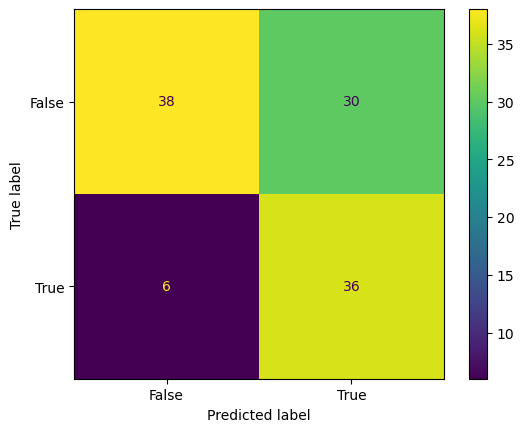

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

Overall this is good performance! We have very high sensitivity. Unfortunately, we have low specificity. 

Best of all there are no mis-classifications so we can probably drop those from the analysis to get a better classification report. 

In [75]:
# Redefine target nodes so as to avoid the 'no answer' class
target_names = {0: 'False', 1: 'True'}#  , 3: 'no answer'}

We will want to take a look at what is causing all the False Positives, perhaps some kind of specific bias that we can prompt around. 

## Evaluation against GPT-4 using base eval settings

In [13]:
gpt4_params = {'model_name': 'gpt-4', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 64}

In [16]:
df['base'] = df.progress_apply(lambda x: no_prompt_complete(x['input'], gpt4_params), axis=1)
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

100%|██████████| 110/110 [12:48<00:00,  6.99s/it]


,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
0,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>system</source><conten...,0,False. According to the ABA Model Rules of Pro...,False,0
1,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>system</source><conten...,0,False. According to the ABA Model Rules of Pro...,False,0
2,"[{'role': 'system', 'content': 'You are LawStu...",True,<input><message><source>system</source><conten...,1,True,True,1
3,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>system</source><conten...,0,False. While a lawyer should be competent in t...,False,0
4,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>system</source><conten...,0,True,True,1


In [19]:
from sklearn.metrics import classification_report
y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.94      0.75      0.84        68
        True       0.70      0.93      0.80        42

    accuracy                           0.82       110
   macro avg       0.82      0.84      0.82       110
weighted avg       0.85      0.82      0.82       110



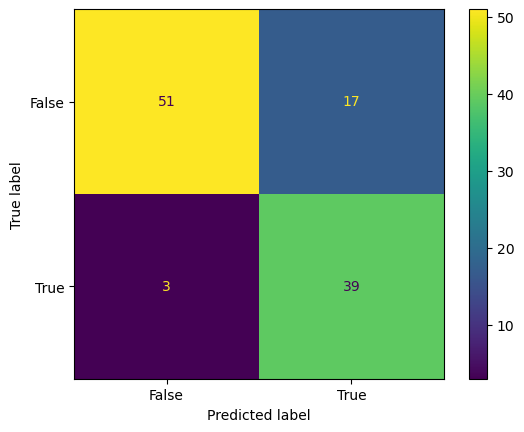

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

GPT-4 does signficantly better than GPT-3.5 in this example, as expected. Let's see if chatXML helps or hurts. 

In [25]:
out = df.sample(1)
print(out.formatted_input.values[0])
print(out.ideal.values[0])

<input><message><source>system</source><content>You are LawStudentGPT. Answer the following True/False question according to the ABA Model Rules of Professional Conduct.</content></message><message><source>user</source><content>A lawyer is allowed to reveal information relating to the representation of a client to establish a defense in a controversy between the lawyer and the client.</content></message></input>
True


## ChatXML using GPT-3.5 and one example. 

In [7]:
from expert import LanguageExpert
single_example_prompt = {
    'name': 'eval_executor', 
    'system_message': "I am an expert evaluator. I will take your input and output a response in the requested format.", 
    'description': 'Takes eval messages as input and outputs a response in the requested format.', 
    'example_input': '''<input><message><source>system</source><content>You are LawStudentGPT. Answer the following True/False question according to the ABA Model Rules of Professional Conduct.</content></message><message><source>user</source><content>A lawyer is allowed to reveal information relating to the representation of a client to establish a defense in a controversy between the lawyer and the client.</content></message></input>''', 
    'example_output': "<output><message><source>assistant</source><content>True</content></message></output>",
    }
turbo_params = {'model_name': 'gpt-3.5-turbo', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 64}
expert = LanguageExpert(**single_example_prompt, model_params=turbo_params)

In [8]:
df['base'] = df.progress_apply(lambda x: expert(x['formatted_input']), axis=1)
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

100%|██████████| 110/110 [07:39<00:00,  4.17s/it]


,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
0,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>system</source><conten...,0,False. According to Rule 1.1 of the ABA Model ...,False,0
1,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>system</source><conten...,0,False. The ABA Model Rules of Professional Con...,False,0
2,"[{'role': 'system', 'content': 'You are LawStu...",True,<input><message><source>system</source><conten...,1,True. According to Rule 1.1 of the ABA Model R...,True,1
3,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>system</source><conten...,0,<output><message><source>assistant</source><co...,False,0
4,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>system</source><conten...,0,<output><message><source>assistant</source><co...,True,1


In [9]:
from sklearn.metrics import classification_report
y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.77      0.69      0.73        68
        True       0.58      0.67      0.62        42
   no answer       0.00      1.00      0.00         0

    accuracy                           0.68       110
   macro avg       0.45      0.79      0.45       110
weighted avg       0.70      0.68      0.69       110



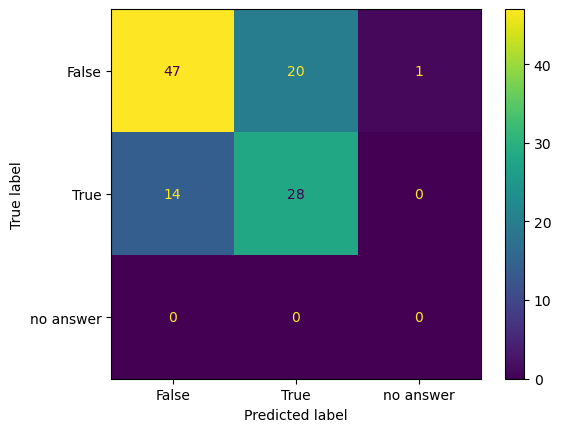

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

In [11]:
df.sample(1).base.values[0]

'True. According to ABA Model Rule 8.3, "a lawyer who knows that another lawyer has committed a violation of the Rules of Professional Conduct that raises a substantial question as to that lawyer\'s honesty, trustworthiness or fitness as a lawyer in other respects, shall inform the appropriate professional authority." This also'

In [12]:
print(df[df.base_pred==3].sample(1)['base'].values[0])

<output><message><source>assistant</source><content>It depends on the circumstances. While an attorney generally has a duty of confidentiality to their client, this duty is not absolute and may be subject to exceptions such as when the disclosure is necessary to prevent reasonably certain death or substantial bodily harm; prevent the client from


Overall performance is about the same as base GPT-3.5 but the distribution of errors is no more evenly shared. We have much fewer false positives but many more true negatives. 

## ChatXML using GPT-4 and one example. 

In [13]:
from expert import LanguageExpert
single_example_prompt = {
    'name': 'eval_executor', 
    'system_message': "I am an expert evaluator. I will take your input and output a response in the requested format.", 
    'description': 'Takes eval messages as input and outputs a response in the requested format.', 
    'example_input': '''<input><message><source>system</source><content>You are LawStudentGPT. Answer the following True/False question according to the ABA Model Rules of Professional Conduct.</content></message><message><source>user</source><content>A lawyer is allowed to reveal information relating to the representation of a client to establish a defense in a controversy between the lawyer and the client.</content></message></input>''', 
    'example_output': "<output><message><source>assistant</source><content>True</content></message></output>",
    }
gpt4_params = {'model_name': 'gpt-4', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 64}
expert = LanguageExpert(**single_example_prompt, model_params=gpt4_params)

In [17]:
df['base'] = df.progress_apply(lambda x: expert(x['formatted_input']), axis=1)
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

100%|██████████| 110/110 [02:57<00:00,  1.62s/it]


,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
0,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>system</source><conten...,0,False,False,0
1,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>system</source><conten...,0,<output><message><source>assistant</source><co...,False,0
2,"[{'role': 'system', 'content': 'You are LawStu...",True,<input><message><source>system</source><conten...,1,True,True,1
3,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>system</source><conten...,0,False,False,0
4,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>system</source><conten...,0,False,False,0


Note the large latency improvement. Brought on by GPT-4 enforcing the structured output. 

Let's see if it cost us on performance at all?

In [23]:
from sklearn.metrics import classification_report
y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.90      0.79      0.84        68
        True       0.72      0.86      0.78        42

    accuracy                           0.82       110
   macro avg       0.81      0.83      0.81       110
weighted avg       0.83      0.82      0.82       110



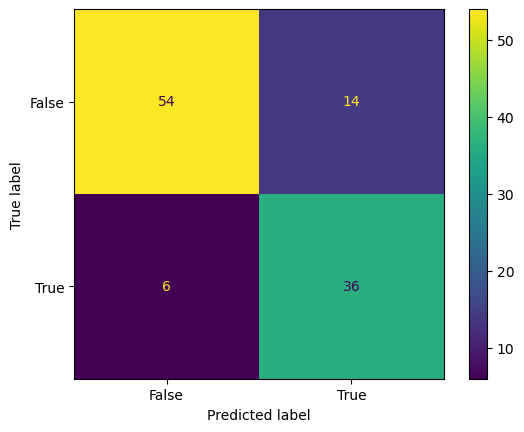

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

Nearly identical performance compared to GPT-4 base. However, we saved completion tokens and reduced inference time by about 10 minutes since GPT-4 stopped wasting  it's time doing COT without use asking.

## Prompt Engineered ChatXML

Before doing this, let's also remove the base system prompt provided by the eval dataset. This will save us 40 tokens, and may help with performance too.

In [51]:
def xmlify(messages):
    xml = ''
    for message in messages:
        if message["role"] == 'system':
            continue
        xml += f'<message><source>{message["role"]}</source><content>{message["content"]}</content></message>'

    xml = f'<input>{xml}</input>'
    return xml
df['formatted_input'] = df['input'].apply(xmlify)
df.head()

,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
0,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,\n<message><source>assistant</source><answer>F...,False,0
1,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,<answer>True</answer>,True,1
2,"[{'role': 'system', 'content': 'You are LawStu...",True,<input><message><source>user</source><content>...,1,\n<assistant_response>\n<message>\n<source>ass...,True,1
3,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,<message><source>Law Student</source><answer>T...,True,1
4,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,\n<message><source>assistant</source><answer>T...,True,1


In [61]:
from expert import LanguageExpert
single_example_prompt = {
    'name': 'Law Student', 
    'system_message': "I am Law-GPT, I have perfect knowledge off the ABA Model Rules of Professional Conduct. To test my skills, give me a True/False questions about the ABA Rules and I will reply with the correct Answer. To justify my answer, I will provide a brief sentence explaining my reasoning.",
    'description': 'Correctly Answer True/False questions about the  ABA Rules of Professional Conduct.', 
    'example_input': '''<input><message><source>user</source><content>A lawyer is required to reveal information relating to the representation of a client if it is necessary to prevent the client from committing a crime that may result in financial injury to another person.</content></message></input>''', 
    'example_output': '''<message><source>assistant</source><reasoning>According to ABA Model Rule 1.6(b)(2), a lawyer may reveal information relating to the representation of a client if it is necessary to prevent the client from committing a crime that will result in financial injury, but they are not required to do so.</reasoning></message>
<message><source>assistant</source><answer>False</answer></message>'''
    }

gpt4_params = {'model_name': 'gpt-4', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 256}
expert = LanguageExpert(**single_example_prompt, model_params=gpt4_params)

In [62]:
df['base'] = df.progress_apply(lambda x: expert(x['formatted_input']), axis=1)
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

100%|██████████| 110/110 [31:15<00:00, 17.05s/it]


,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
0,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,<message><source>assistant</source><reasoning>...,False,0
1,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,<message><source>assistant</source><reasoning>...,False,0
2,"[{'role': 'system', 'content': 'You are LawStu...",True,<input><message><source>user</source><content>...,1,<message><source>assistant</source><reasoning>...,True,1
3,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,<message><source>assistant</source><reasoning>...,False,0
4,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,<message><source>assistant</source><reasoning>...,False,0


In [63]:
from sklearn.metrics import classification_report
y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.92      0.87      0.89        68
        True       0.80      0.88      0.84        42

    accuracy                           0.87       110
   macro avg       0.86      0.87      0.87       110
weighted avg       0.88      0.87      0.87       110



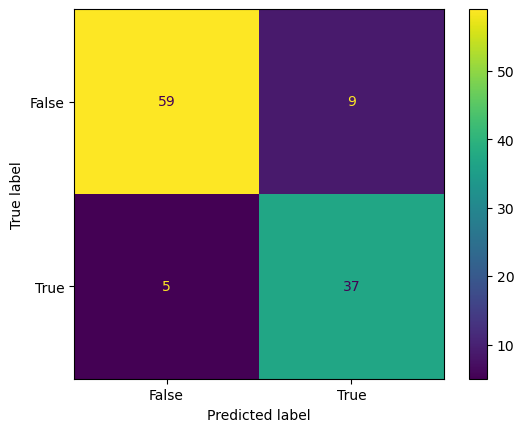

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

Nearly an A student! But we took a massive hit on latency. Let's try Claude out and swap out the example to a True Negative and see how that works. 

## Claude-v1.3 with chain of thought. 

In [43]:
from expert import LanguageExpert
single_example_prompt = {
    'name': 'Law Student', 
    'system_message': "I am Law-GPT, I have perfect knowledge off the ABA Model Rules of Professional Conduct. To test my skills, give me a True/False questions about the ABA Rules and I will reply with the correct Answer.",
    'description': 'Correctly Answer True/False questions about the  ABA Rules of Professional Conduct. To justify my answer, I will provide a brief sentence explaining my reasoning.', 
    'example_input': '''<input><message><source>user</source><content>A lawyer is required to reveal information relating to the representation of a client if it is necessary to prevent the client from committing a crime that may result in financial injury to another person.</content></message></input>''', 
    'example_output': '''<message><source>assistant</source><reasoning>According to ABA Model Rule 1.6(b)(2), a lawyer may reveal information relating to the representation of a client if it is necessary to prevent the client from committing a crime that will result in financial injury, but they are not required to do so.</reasoning></message>
<message><source>assistant</source><answer>False</answer></message>'''
    }
claude_params = {'model_name': 'claude-v1.3', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 128}
expert = LanguageExpert(**single_example_prompt, model_params=claude_params)

In [44]:
df['base'] = df.progress_apply(lambda x: expert(x['formatted_input']), axis=1)
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

100%|██████████| 110/110 [04:29<00:00,  2.45s/it]


,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
0,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,\n<message><source>assistant</source><answer>F...,False,0
1,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,<message><source>assistant</source><answer>Fal...,False,0
2,"[{'role': 'system', 'content': 'You are LawStu...",True,<input><message><source>user</source><content>...,1,<message><source>assistant</source><answer> Tr...,True,1
3,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,\n<message><source>assistant</source><answer>T...,True,1
4,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,<message><source>assistant</source><reasoning>...,True,1


In [45]:
from sklearn.metrics import classification_report
y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.79      0.85      0.82        68
        True       0.73      0.64      0.68        42

    accuracy                           0.77       110
   macro avg       0.76      0.75      0.75       110
weighted avg       0.77      0.77      0.77       110



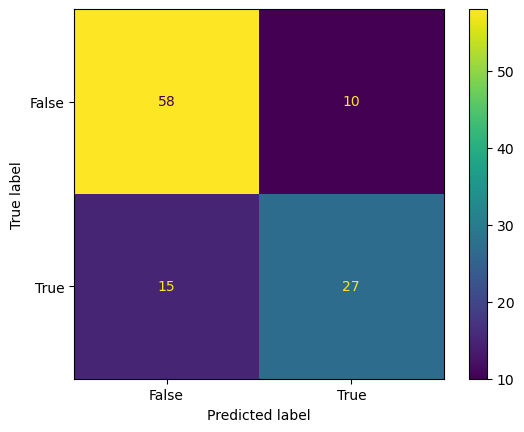

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

Looks like GPT-4 is the crown kind. Anthropic puts up a good fight though! Exceeds GPT-3.5 performance across the board and with the lowes latency of any of the models. 

## Claude-v1.3 without chain of thought. 

In [65]:
from expert import LanguageExpert
single_example_prompt = {
    'name': 'Law Student', 
    'system_message': "I am Law-GPT, I have perfect knowledge off the ABA Model Rules of Professional Conduct. To test my skills, give me a True/False questions about the ABA Rules and I will reply with the correct Answer.",
    'description': 'Correctly Answer True/False questions about the  ABA Rules of Professional Conduct.', 
    'example_input': '''<input><content>A lawyer is required to reveal information relating to the representation of a client if it is necessary to prevent the client from committing a crime that may result in financial injury to another person.</content></message></input>''', 
    'example_output': '''<message><answer>False</answer></message>'''
    }
claude_params = {'model_name': 'claude-v1.3', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 128}
expert = LanguageExpert(**single_example_prompt, model_params=claude_params)

In [66]:
df['base'] = df.progress_apply(lambda x: expert(x['formatted_input']), axis=1)
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

100%|██████████| 110/110 [02:17<00:00,  1.25s/it]


,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
0,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,<message><answer>True</answer></message>,True,1
1,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,\n<example_output> \n<message>\n<answer>False<...,False,0
2,"[{'role': 'system', 'content': 'You are LawStu...",True,<input><message><source>user</source><content>...,1,\n<message><answer>True</answer></message>,True,1
3,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,\n<assistant_response>\n<message>\n<answer>Tru...,True,1
4,"[{'role': 'system', 'content': 'You are LawStu...",False,<input><message><source>user</source><content>...,0,<message><answer>True</answer></message>,True,1


In [67]:
from sklearn.metrics import classification_report
y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.83      0.65      0.73        68
        True       0.58      0.79      0.67        42

    accuracy                           0.70       110
   macro avg       0.70      0.72      0.70       110
weighted avg       0.73      0.70      0.70       110



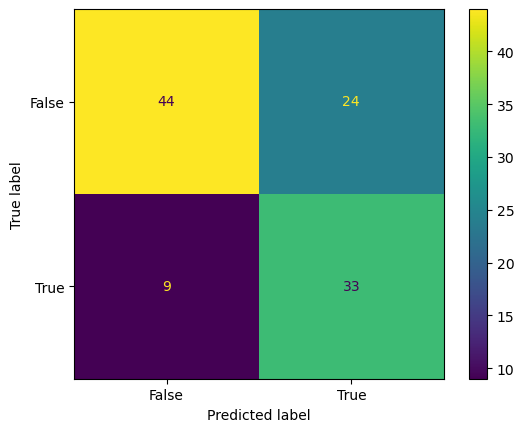

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

Even without chain of thought, we get excellent results. And we cut inference time in half! 

From now on due to cost and latency and an exponential explosion of permutations, I will be doing all testing in Claude since it's my personal favorite. However, I will continue writing these using my expert backend which easily supports OpenAI and can be adapted to support any other backend.

Ideall, prompt engineering insights should be somewhat cross platform, but that still remains to be proven.